
=== Model Comparison ===
Linear Regression: MAE=6.85, RMSE=8.36, R2=0.94
Random Forest: MAE=7.63, RMSE=9.56, R2=0.92
Gradient Boosting: MAE=7.94, RMSE=9.52, R2=0.92

Best Parameters from Random Search: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}

=== Tuned Model Performance (Random Forest) ===
MAE: 7.77099019311244
RMSE: 9.706709256088034
R²: 0.9181068259593059

Cross-validated MAE: 8.092171763277


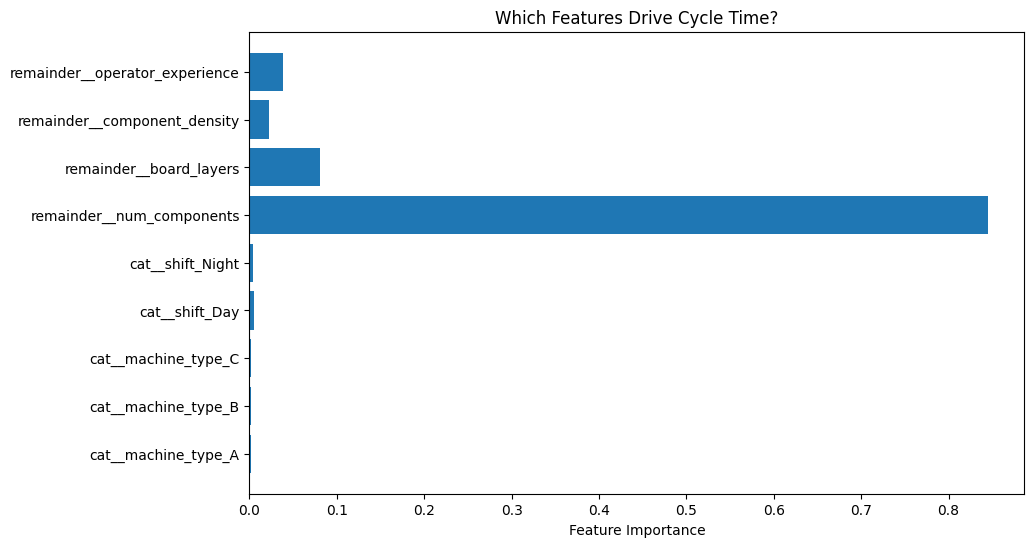

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


df = pd.read_csv(r"D:\Srm-project\pcb_cycle_dataset_core.csv")

X = df.drop("cycle_time", axis=1)
y = df["cycle_time"]


categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
}


results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

print("\n=== Model Comparison ===")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.2f}")


param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("\nBest Parameters from Random Search:", search.best_params_)

best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\n=== Tuned Model Performance (Random Forest) ===")
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R²:", r2_score(y_test, y_pred_best))


scores = cross_val_score(best_model, X_encoded, y, cv=5, scoring="neg_mean_absolute_error")
print("\nCross-validated MAE:", -scores.mean())


importances = best_model.feature_importances_
encoded_features = preprocessor.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.barh(encoded_features, importances)
plt.xlabel("Feature Importance")
plt.title("Which Features Drive Cycle Time?")
plt.show()
